<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F3D8F5;">

# What is the inhibitory connectivity underlying surround suppression in the mouse primary visual cortex?

## Background
Surround suppression is a feature of sensory processing which, in visual systems, facilitates the definition of objects against their backgrounds (Kiniklioglu & Kaiser, 2025) by sharpening receptive fields as suppression strength increases (Plomp et al., 2019). While much work has been directed to describing the functional aspect of surround suppression, the underlying inhibitory structural connectivity has received less attention. We propose the use of the V1DD dataset, which comprises both structural and functional data, to address several questions about the inhibitory connectivity subserving surround suppression across the layers of the mouse primary visual cortex. 
    
## Methods
### Feature extraction:
Morphological metrics: total axonal length/radius, branch counts, maximum branch order, output synapse counts, synaptic density per unit length, number of distinct target types, layer/radial distributions, soma depth
Activity metrics: Differences in ΔF/F for windowed gabor - full-field gabor, suppression index
Synapse spatial targeting: Comparison of SOM+ vs other inhibitory interneurons for probability of synapsing
    
## Statistics:
Make a null connectivity model (by shuffling connections between cells): If the cell is connected to the inhibitory cells, then this cell may be more functionally capable of doing surround suppression, and the cells that could have been connected to inhibitory cells, will be less capable. Whether this is actually the case is unclear, and making a null connectivity model will help with this question.
Spearman correlation for cell connectivity probabilities? Maybe could do paired tests, depends on the final form of data.


In [1]:
# Import packages
import sys
from os.path import join as pjoin
import platform

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from standard_transform.datasets import v1dd_ds

# Add the directory for the data and utilities
mat_version = 1196

platstring = platform.platform()
system = platform.system()
if system == "Darwin":
    # macOS
    data_root = "/Volumes/Brain2025/"
elif system == "Windows":
    # Windows (replace with the drive letter of USB drive)
    data_root = "E:/"
elif "amzn" in platstring:
    # then on CodeOcean
    data_root = "/data/"
else:
    # then your own linux platform
    # EDIT location where you mounted hard drive
    data_root = "/media/$USERNAME/Brain2025/"

# Set the directory to load prepared data and utility code
data_dir = pjoin(data_root, f"v1dd_{mat_version}")
utils_dir = pjoin("..", "utils")

# Add utilities to path
sys.path.append(utils_dir)
from data_io import *
from utils import filter_synapse_table, check_index, adjacencyplot, calculate_lateral_distances
from data_io import _get_data_dir

In [2]:
# load the cell type information
ct_df = pd.read_feather(f"{data_dir}/soma_and_cell_type_{mat_version}.feather")

# Load synapses 
syn_df = syn_df = pd.read_feather(f"{data_dir}/syn_df_all_to_proofread_to_all_{mat_version}.feather")

# Load the proofreading info
proofread_ids = np.load(pjoin(data_dir, f"proofread_axon_list_{mat_version}.npy"))

# Mark proofread neurons in the synapse dataframe so we can filter out everything else
syn_df["pre_proofread"] = syn_df["pre_pt_root_id"].isin(proofread_ids)
syn_df["post_proofread"] = syn_df["post_pt_root_id"].isin(proofread_ids)

# These are approximate depth values in post-transformed microns for the pial surface, L1-L2/3 border, L2/3-L4 border, etc. down to the L6-wm border.
layer_bounds = [
    -15,
    91,
    261,
    391,
    537,
    753,
]  

In [3]:
# Convert from nanometers to microns
ct_df["soma_depth"] = (
    ct_df["pt_position_trform_y"] / 1_000
)  

ct_df.soma_depth.head()  # Approximate cell depth from pial surface in microns

0    549.910283
1    595.962276
2    203.770728
3    117.514626
4    475.075415
Name: soma_depth, dtype: float64

In [4]:
# What we are about to do requres that no root ids are duplicated in this, so let's double check:
ct_df.drop_duplicates("pt_root_id", keep=False, inplace=True)

In [5]:
# Add proofreading information
ct_df["is_proofread"] = ct_df["pt_root_id"].isin(proofread_ids)
ct_df.head(5)

,id,pt_position_x,pt_position_y,pt_position_z,pt_position_trform_x,pt_position_trform_y,pt_position_trform_z,pt_root_id,volume,cell_type_coarse,cell_type,soma_depth,is_proofread
2,203262,624680,531094,283770,-252082.627894,203770.728235,21544.029756,864691132654552792,338.276613,E,L3-IT,203.770728,False
3,350562,894573,478559,163530,20989.259196,117514.626427,-98554.035375,864691132773514104,326.965400,E,L2-IT,117.514626,False
4,718122,1729859,674111,781200,803635.726721,475075.415268,467669.881328,864691132774106773,333.888647,None,None,475.075415,False
5,680726,1640231,677370,768015,713993.992148,475136.490033,454028.344107,864691132780109973,706.847075,None,None,475.136490,False
6,544582,1316562,974035,157590,334827.643688,613565.716183,-236450.684115,864691132736203675,200.069363,None,None,613.565716,False


In [6]:
# Add the synapse depth in consistent coordinates
syn_df["synapse_depth"] = v1dd_ds.transform_nm.apply_dataframe(
    "ctr_pt_position", syn_df, projection="y"
)

syn_df.head(5)

,id,pre_pt_position_x,pre_pt_position_y,pre_pt_position_z,post_pt_position_x,post_pt_position_y,post_pt_position_z,ctr_pt_position_x,ctr_pt_position_y,ctr_pt_position_z,size,pre_pt_root_id,post_pt_root_id,pre_proofread,post_proofread,synapse_depth
0,354386968,758200.5,802316.1,304380.0,757861.0,802558.6,304650.0,757967.7,802597.4,304380.0,240,864691132536286810,864691132734919083,True,False,465.734071
1,378070488,792063.2,514342.5,183735.0,792664.6,514284.3,183915.0,792412.4,514294.0,183735.0,3056,864691132572190492,864691132606767301,True,False,155.489291
2,499493001,977071.3,390075.8,191340.0,976974.3,390104.9,190935.0,976838.5,390337.7,190935.0,1346,864691132573738810,864691132747578447,True,False,37.067491
3,119675985,444260.0,602544.6,3285.0,443988.4,602311.8,3555.0,444182.4,602370.0,3780.0,3637,864691132572564252,864691132654028028,True,False,193.912163
4,220616943,574501.9,337249.6,258570.0,574152.7,337016.8,258570.0,574337.0,336900.4,258570.0,420,864691132558380553,864691132828255906,True,False,5.689342


In [7]:
# add the postsynaptic euclidean distance from the presynaptic cell/neuron

def add_euclidean_distance(df, x_col='x', y_col='y', z_col='z', new_col='distance'):
    """
    Calculate Euclidean distance from origin (0,0,0) for x, y, z coordinates in a DataFrame.

    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing x, y, z coordinate columns.
    x_col, y_col, z_col : str
        Names of the columns for x, y, z coordinates.
    new_col : str
        Name of the new column to store distances.

    Returns:
    --------
    pandas.DataFrame
        DataFrame with an additional column containing Euclidean distances.
    """
    df[new_col] = np.sqrt(df[x_col]**2 + df[y_col]**2 + df[z_col]**2)
    return df


In [8]:
# copy the synapses dataframe
syn_df_ecldn = syn_df.copy()
syn_df_ecldn.head(5)

,id,pre_pt_position_x,pre_pt_position_y,pre_pt_position_z,post_pt_position_x,post_pt_position_y,post_pt_position_z,ctr_pt_position_x,ctr_pt_position_y,ctr_pt_position_z,size,pre_pt_root_id,post_pt_root_id,pre_proofread,post_proofread,synapse_depth
0,354386968,758200.5,802316.1,304380.0,757861.0,802558.6,304650.0,757967.7,802597.4,304380.0,240,864691132536286810,864691132734919083,True,False,465.734071
1,378070488,792063.2,514342.5,183735.0,792664.6,514284.3,183915.0,792412.4,514294.0,183735.0,3056,864691132572190492,864691132606767301,True,False,155.489291
2,499493001,977071.3,390075.8,191340.0,976974.3,390104.9,190935.0,976838.5,390337.7,190935.0,1346,864691132573738810,864691132747578447,True,False,37.067491
3,119675985,444260.0,602544.6,3285.0,443988.4,602311.8,3555.0,444182.4,602370.0,3780.0,3637,864691132572564252,864691132654028028,True,False,193.912163
4,220616943,574501.9,337249.6,258570.0,574152.7,337016.8,258570.0,574337.0,336900.4,258570.0,420,864691132558380553,864691132828255906,True,False,5.689342


In [9]:
# compute the euclidean distance for each post_pt_root_id
syn_df_ecldn = add_euclidean_distance(syn_df_ecldn, x_col='post_pt_position_x', y_col='post_pt_position_y', z_col='post_pt_position_z', new_col='euclidean_distance')
syn_df_ecldn.head()

,id,pre_pt_position_x,pre_pt_position_y,pre_pt_position_z,post_pt_position_x,post_pt_position_y,post_pt_position_z,ctr_pt_position_x,ctr_pt_position_y,ctr_pt_position_z,size,pre_pt_root_id,post_pt_root_id,pre_proofread,post_proofread,synapse_depth,euclidean_distance
0,354386968,758200.5,802316.1,304380.0,757861.0,802558.6,304650.0,757967.7,802597.4,304380.0,240,864691132536286810,864691132734919083,True,False,465.734071,1.145105e+06
1,378070488,792063.2,514342.5,183735.0,792664.6,514284.3,183915.0,792412.4,514294.0,183735.0,3056,864691132572190492,864691132606767301,True,False,155.489291,9.626163e+05
2,499493001,977071.3,390075.8,191340.0,976974.3,390104.9,190935.0,976838.5,390337.7,190935.0,1346,864691132573738810,864691132747578447,True,False,37.067491,1.069166e+06
3,119675985,444260.0,602544.6,3285.0,443988.4,602311.8,3555.0,444182.4,602370.0,3780.0,3637,864691132572564252,864691132654028028,True,False,193.912163,7.482766e+05
4,220616943,574501.9,337249.6,258570.0,574152.7,337016.8,258570.0,574337.0,336900.4,258570.0,420,864691132558380553,864691132828255906,True,False,5.689342,7.142059e+05


In [10]:
# Let's make a dataframe where each row is a "connection" between a presynaptic and postsynaptic neuron, with the number of synapses and their summed size as two different measures of the connection weight.
# This involves a "group-by" on both the presynaptic and postsynaptic neuron IDs and aggregating both the count of synapses, summed synapse size, average euclidean distance.

connectivity_df = (
    syn_df_ecldn.query("pre_proofread and post_proofread")
    .groupby(["pre_pt_root_id", "post_pt_root_id"])
    .agg(num_synapses=("pre_pt_root_id", "count"), sum_size=("size", "sum"),avg_eucl_dist=("euclidean_distance", "mean"))
    .reset_index()
)

connectivity_df.head()

,pre_pt_root_id,post_pt_root_id,num_synapses,sum_size,avg_eucl_dist
0,864691132534275418,864691132619649223,1,2620,1.123083e+06
1,864691132534275418,864691132656860272,1,898,1.091005e+06
2,864691132534275418,864691132659029623,3,3828,1.050177e+06
3,864691132534275418,864691132663192644,1,4488,1.156506e+06
4,864691132534275418,864691132663898692,1,1556,1.187419e+06


In [11]:
# add the synaptic ratio - divide sum_size by number of synapses
connectivity_df["synaptic_ratio"] = connectivity_df["sum_size"]/connectivity_df["num_synapses"]
connectivity_df.head()

,pre_pt_root_id,post_pt_root_id,num_synapses,sum_size,avg_eucl_dist,synaptic_ratio
0,864691132534275418,864691132619649223,1,2620,1.123083e+06,2620.0
1,864691132534275418,864691132656860272,1,898,1.091005e+06,898.0
2,864691132534275418,864691132659029623,3,3828,1.050177e+06,1276.0
3,864691132534275418,864691132663192644,1,4488,1.156506e+06,4488.0
4,864691132534275418,864691132663898692,1,1556,1.187419e+06,1556.0


In [12]:
# Move column 'synaptic_ratio' to the fourth position
col = connectivity_df.pop('synaptic_ratio')
connectivity_df.insert(4, 'synaptic_ratio', col)
connectivity_df.head()

,pre_pt_root_id,post_pt_root_id,num_synapses,sum_size,synaptic_ratio,avg_eucl_dist
0,864691132534275418,864691132619649223,1,2620,2620.0,1.123083e+06
1,864691132534275418,864691132656860272,1,898,898.0,1.091005e+06
2,864691132534275418,864691132659029623,3,3828,1276.0,1.050177e+06
3,864691132534275418,864691132663192644,1,4488,4488.0,1.156506e+06
4,864691132534275418,864691132663898692,1,1556,1556.0,1.187419e+06


In [13]:
# Merge with the cell type dataframe

connectivity_ct_df = connectivity_df.merge(
    ct_df[["pt_root_id", "soma_depth", "cell_type_coarse", "cell_type"]].rename(
        columns={
            "pt_root_id": "pre_pt_root_id",
            "soma_depth": "soma_depth_pre",
            "cell_type": "cell_type_pre",
            "cell_type_coarse": "ei_pre",
        }
    ),
    on="pre_pt_root_id",
).merge(
    ct_df[["pt_root_id", "soma_depth", "cell_type_coarse", "cell_type"]].rename(
        columns={
            "pt_root_id": "post_pt_root_id",
            "soma_depth": "soma_depth_post",
            "cell_type": "cell_type_post",
            "cell_type_coarse": "ei_post",
        }
    ),
    on="post_pt_root_id",
)

connectivity_ct_df.head(10)


,pre_pt_root_id,post_pt_root_id,num_synapses,sum_size,synaptic_ratio,avg_eucl_dist,soma_depth_pre,ei_pre,cell_type_pre,soma_depth_post,ei_post,cell_type_post
0,864691132534275418,864691132619649223,1,2620,2620.0,1.123083e+06,313.619432,E,L4-IT,448.697962,I,DTC
1,864691132534275418,864691132656860272,1,898,898.0,1.091005e+06,313.619432,E,L4-IT,357.350410,I,DTC
2,864691132534275418,864691132659029623,3,3828,1276.0,1.050177e+06,313.619432,E,L4-IT,349.799057,I,DTC
3,864691132534275418,864691132663192644,1,4488,4488.0,1.156506e+06,313.619432,E,L4-IT,480.704383,E,L5-ET
4,864691132534275418,864691132663898692,1,1556,1556.0,1.187419e+06,313.619432,E,L4-IT,623.202753,I,PTC
5,864691132534275418,864691132666054744,1,4965,4965.0,1.146237e+06,313.619432,E,L4-IT,465.692836,E,L5-ET
6,864691132534275418,864691132689698824,1,1436,1436.0,1.184891e+06,313.619432,E,L4-IT,420.092290,I,DTC
7,864691132534275418,864691132700001158,1,631,631.0,1.137687e+06,313.619432,E,L4-IT,427.743622,E,L5-ET
8,864691132534275418,864691132714139653,1,270,270.0,1.281283e+06,313.619432,E,L4-IT,480.999345,I,DTC
9,864691132534275418,864691132739485851,1,3425,3425.0,1.254537e+06,313.619432,E,L4-IT,436.666528,E,L5-ET


In [14]:
# find I to E connections

connectivity_ct_IE = connectivity_ct_df.query('ei_pre == "I" and ei_post == "E"')
connectivity_ct_IE.head()

,pre_pt_root_id,post_pt_root_id,num_synapses,sum_size,synaptic_ratio,avg_eucl_dist,soma_depth_pre,ei_pre,cell_type_pre,soma_depth_post,ei_post,cell_type_post
85,864691132536286810,864691132563376846,1,231,231.000000,1.165604e+06,481.95328,I,DTC,534.001457,E,L5-NP
88,864691132536286810,864691132596046903,1,702,702.000000,1.270114e+06,481.95328,I,DTC,448.928478,E,L5-ET
89,864691132536286810,864691132598805055,1,415,415.000000,9.551189e+05,481.95328,I,DTC,167.400869,E,L2-IT
90,864691132536286810,864691132606072261,1,240,240.000000,1.311040e+06,481.95328,I,DTC,420.578933,E,L5-NP
91,864691132536286810,864691132606660376,6,6121,1020.166667,1.139007e+06,481.95328,I,DTC,415.773718,E,L5-ET


In [15]:
connectivity_ct_IE["cell_type_post"].value_counts()

cell_type_post
L3-IT    14818
L5-ET     7010
L2-IT     5910
L4-IT     4088
L5-IT     3107
L6-IT     1470
L6-CT     1173
L5-NP      500
Name: count, dtype: int64

In [16]:
connectivity_ct_IE["cell_type_pre"].value_counts()

cell_type_pre
DTC    17432
PTC    16885
STC     2613
ITC     1146
Name: count, dtype: int64

In [40]:
connectivity_ct_IE

,pre_pt_root_id,post_pt_root_id,num_synapses,sum_size,synaptic_ratio,avg_eucl_dist,soma_depth_pre,ei_pre,cell_type_pre,soma_depth_post,ei_post,cell_type_post
85,864691132536286810,864691132563376846,1,231,231.000000,1.165604e+06,481.953280,I,DTC,534.001457,E,L5-NP
88,864691132536286810,864691132596046903,1,702,702.000000,1.270114e+06,481.953280,I,DTC,448.928478,E,L5-ET
89,864691132536286810,864691132598805055,1,415,415.000000,9.551189e+05,481.953280,I,DTC,167.400869,E,L2-IT
90,864691132536286810,864691132606072261,1,240,240.000000,1.311040e+06,481.953280,I,DTC,420.578933,E,L5-NP
91,864691132536286810,864691132606660376,6,6121,1020.166667,1.139007e+06,481.953280,I,DTC,415.773718,E,L5-ET
...,...,...,...,...,...,...,...,...,...,...,...,...
91993,864691133311980112,864691132903371002,1,390,390.000000,1.140173e+06,134.100507,I,ITC,241.313404,E,L3-IT
91994,864691133311980112,864691132925225513,1,234,234.000000,1.159151e+06,134.100507,I,ITC,224.076075,E,L3-IT
91995,864691133311980112,864691132930886632,1,673,673.000000,1.285458e+06,134.100507,I,ITC,535.923251,E,L5-ET
91996,864691133311980112,864691132931817448,1,963,963.000000,1.206888e+06,134.100507,I,ITC,438.395845,E,L5-ET


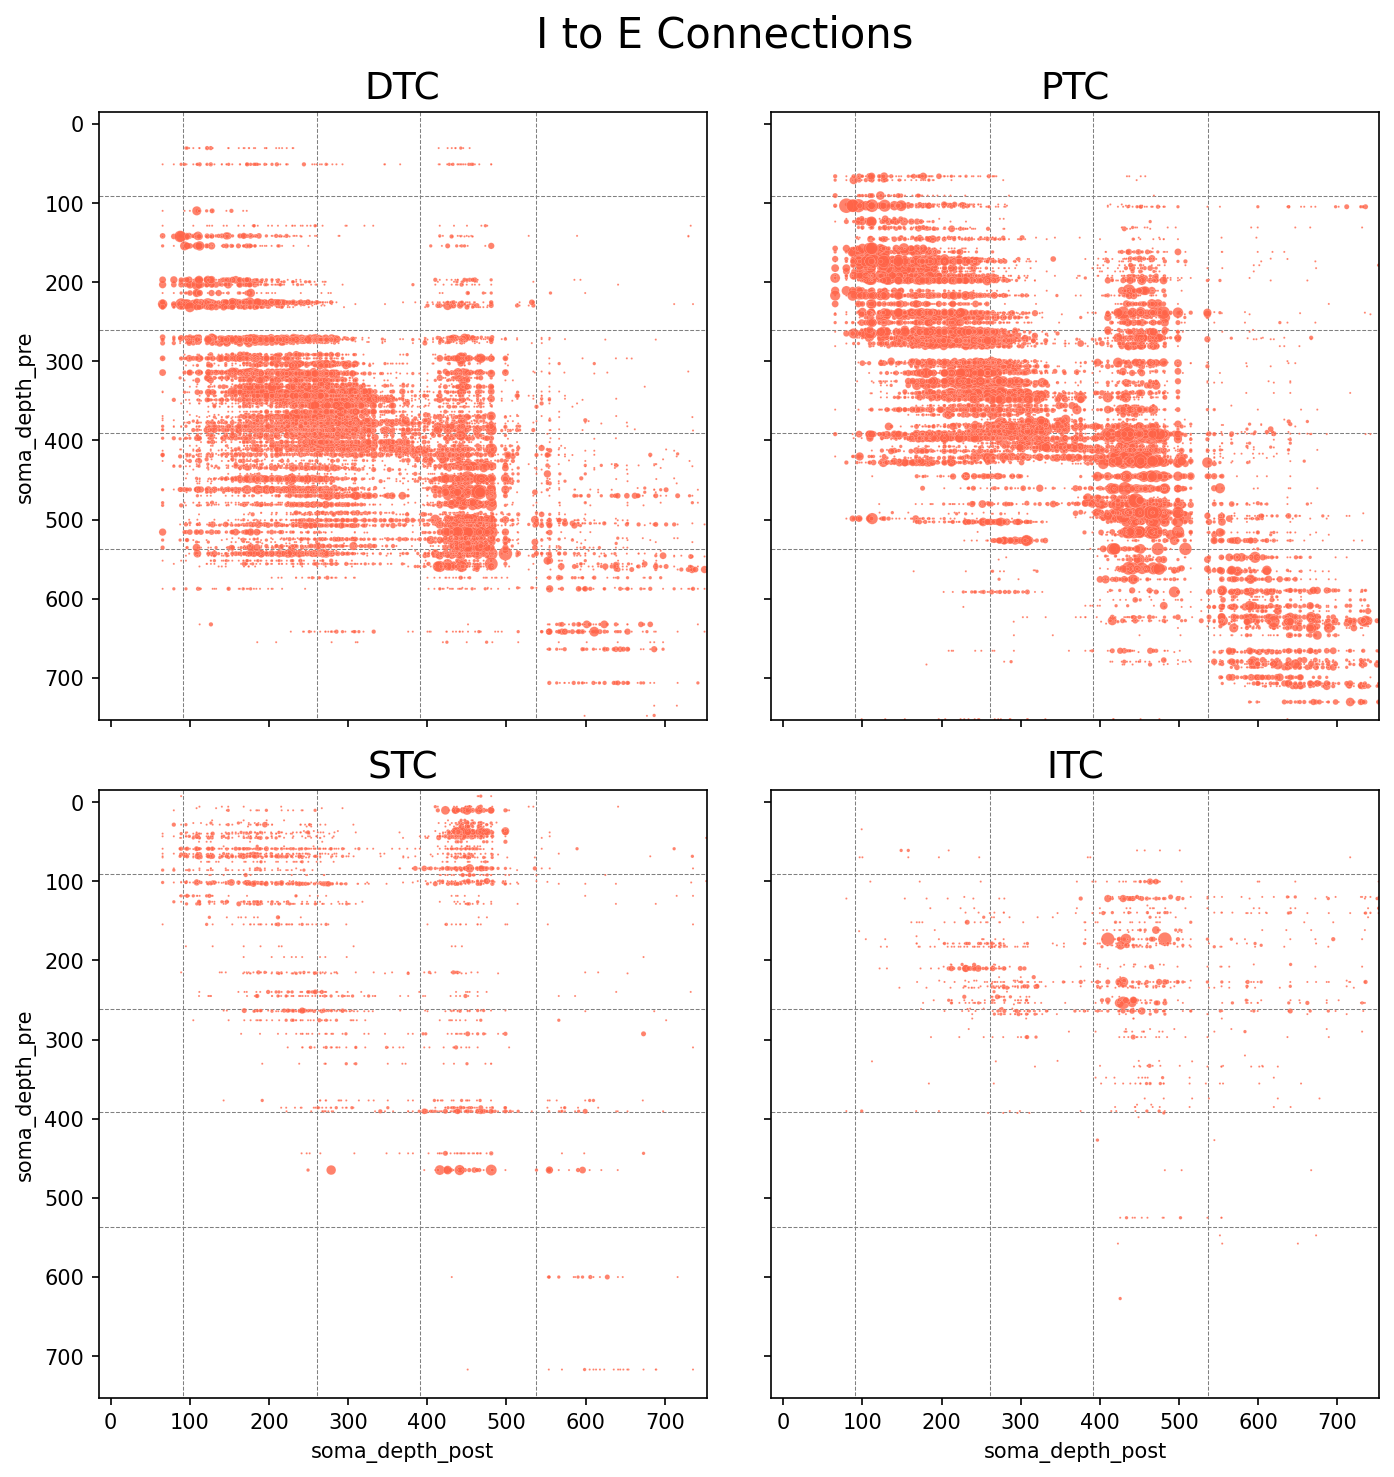

In [33]:
# visualize the IE synaptic connectivity across layer depth

fig, axes = plt.subplots(
    figsize=(10, 10),
    ncols=2,
    nrows=2,
    sharex=True,
    sharey=True,
    dpi=150,
    tight_layout=True,
)

ie_palette = {"I": "tomato", "E": "navy"}
ct_type = [["DTC", "PTC"], ["STC", "ITC"]]
#print(x)

for pre_ind in [0, 1]:
    for post_ind in [0, 1]:
        ax = axes[pre_ind, post_ind]
        #pre_cat = ct_category[pre_ind]
        #post_cat = ct_category[post_ind]
        cell_type = ct_type[pre_ind][post_ind]
        sns.scatterplot(
            data=connectivity_ct_IE.query(
                'cell_type_pre == @cell_type'
            ),
            x="soma_depth_post",
            y="soma_depth_pre",
            #hue="pre_pt_root_id",
            #data = connectivity_ct_df.query('ei_pre == "I" and ei_post == "E" and cell_type_post == @cell_type'),
            hue="ei_pre",
            ax=ax,
            size="num_synapses",
            sizes=(1, 50),
            size_norm=(1, 30),  # Sets the value range mapping to the range in "sizes".
            legend=False,
            palette=ie_palette,
            alpha=0.8,
        )

        ax.set_xlim(layer_bounds[0], layer_bounds[-1])
        ax.set_ylim(layer_bounds[0], layer_bounds[-1])
        ax.set_aspect("equal")

        ax.set_title(f"{cell_type}",fontsize = 18)

        # add horizontal and vertical lines where layers are
        ax.hlines(
            layer_bounds[1:],
            layer_bounds[0],
            layer_bounds[-1],
            color="gray",
            linestyle="--",
            linewidth=0.5,
            zorder=-10,
        )  # The `zorder` parameter puts the lines behind the scatter points
        ax.vlines(
            layer_bounds[1:],
            layer_bounds[0],
            layer_bounds[-1],
            color="gray",
            linestyle="--",
            linewidth=0.5,
            zorder=-10,
        )

ax.invert_yaxis()
plt.suptitle("I to E Connections", fontsize = 20)

# Save the figure as a PNG file
plt.savefig(f"/results/structure/figures/ItoE_synapticConnections.png")


In [18]:
ct_type = [["DTC", "PTC"], ["STC", "ITC"]]
np.array(ct_type).shape
print(ct_type[1][0])

STC


In [21]:
ct_type[pre_ind][post_ind]

'ITC'

In [34]:
# find E to I connections
connectivity_ct_EI = connectivity_ct_df.query('ei_pre == "E" and ei_post == "I"')
connectivity_ct_EI.head()


,pre_pt_root_id,post_pt_root_id,num_synapses,sum_size,synaptic_ratio,avg_eucl_dist,soma_depth_pre,ei_pre,cell_type_pre,soma_depth_post,ei_post,cell_type_post
0,864691132534275418,864691132619649223,1,2620,2620.0,1.123083e+06,313.619432,E,L4-IT,448.697962,I,DTC
1,864691132534275418,864691132656860272,1,898,898.0,1.091005e+06,313.619432,E,L4-IT,357.350410,I,DTC
2,864691132534275418,864691132659029623,3,3828,1276.0,1.050177e+06,313.619432,E,L4-IT,349.799057,I,DTC
4,864691132534275418,864691132663898692,1,1556,1556.0,1.187419e+06,313.619432,E,L4-IT,623.202753,I,PTC
6,864691132534275418,864691132689698824,1,1436,1436.0,1.184891e+06,313.619432,E,L4-IT,420.092290,I,DTC


In [78]:
len(connectivity_ct_EI)

19606

In [50]:
# count unique post_opt_root_ids
connectivity_ct_IE['post_pt_root_id'].value_counts()

post_pt_root_id
864691132669405014    172
864691132734343191    169
864691132688867336    160
864691132848998867    154
864691132830577529    151
                     ... 
864691132741048665      5
864691132786939218      4
864691132702645394      4
864691132781219967      2
864691132731452144      2
Name: count, Length: 674, dtype: int64

In [51]:
connectivity_ct_IE['post_pt_root_id'].unique()

array([864691132563376846, 864691132596046903, 864691132598805055,
       864691132606072261, 864691132606660376, 864691132608140569,
       864691132613539645, 864691132644003126, 864691132649386919,
       864691132655360252, 864691132656139260, 864691132657942744,
       864691132663192644, 864691132663800900, 864691132666054744,
       864691132669656346, 864691132670830031, 864691132672005146,
       864691132682319663, 864691132683942600, 864691132684814532,
       864691132685186469, 864691132685582532, 864691132689966614,
       864691132690620182, 864691132690646038, 864691132691044586,
       864691132692478968, 864691132695096809, 864691132710501931,
       864691132710866437, 864691132713507077, 864691132714014725,
       864691132717149199, 864691132720003059, 864691132725878426,
       864691132729719982, 864691132731780403, 864691132732388891,
       864691132734343191, 864691132739485851, 864691132741826140,
       864691132742621593, 864691132755400820, 864691132755677

In [81]:
# Keep only matching IDs
A,B = connectivity_ct_IE.copy(), connectivity_ct_EI.copy()

matching_root_ids = A[A["post_pt_root_id"].isin(B["pre_pt_root_id"])]["pre_pt_root_id"].unique()

print(len(matching_root_ids))
#print()
print("Matching IDs:", matching_root_ids)
#matching_root_ids.value_counts()

443
Matching IDs: [864691132536286810 864691132536904794 864691132544823185
 864691132557909513 864691132558380553 864691132558474249
 864691132562471396 864691132564013006 864691132564167630
 864691132565313230 864691132572190492 864691132574470970
 864691132577952020 864691132578625044 864691132579592205
 864691132580250381 864691132581517842 864691132586288610
 864691132586397666 864691132589651341 864691132592012797
 864691132593050621 864691132594791991 864691132596311607
 864691132596553783 864691132596647735 864691132603082157
 864691132604116909 864691132604517549 864691132606796229
 864691132606905112 864691132607203353 864691132607332633
 864691132608097049 864691132609124280 864691132616354625
 864691132617102554 864691132617864666 864691132618678215
 864691132619181018 864691132619241946 864691132619312346
 864691132619338714 864691132619649223 864691132619923655
 864691132622450882 864691132623325071 864691132623989442
 864691132624685004 864691132625807759 864691132628245

In [76]:
# index the matching IDs from postynaptic IE into EI connections
# thus  where IE post_pt_root_id == EI pre_pt_root_id 

connectivity_ct_IE_EI_mgd = B[B["pre_pt_root_id"].isin(A["post_pt_root_id"])]
print(len(connectivity_ct_IE_EI_mgd))
connectivity_ct_IE_EI_mgd.head()

#B[A["post_pt_root_id"].isin(B["pre_pt_root_id"])]

19606


,pre_pt_root_id,post_pt_root_id,num_synapses,sum_size,synaptic_ratio,avg_eucl_dist,soma_depth_pre,ei_pre,cell_type_pre,soma_depth_post,ei_post,cell_type_post
0,864691132534275418,864691132619649223,1,2620,2620.0,1.123083e+06,313.619432,E,L4-IT,448.697962,I,DTC
1,864691132534275418,864691132656860272,1,898,898.0,1.091005e+06,313.619432,E,L4-IT,357.350410,I,DTC
2,864691132534275418,864691132659029623,3,3828,1276.0,1.050177e+06,313.619432,E,L4-IT,349.799057,I,DTC
4,864691132534275418,864691132663898692,1,1556,1556.0,1.187419e+06,313.619432,E,L4-IT,623.202753,I,PTC
6,864691132534275418,864691132689698824,1,1436,1436.0,1.184891e+06,313.619432,E,L4-IT,420.092290,I,DTC


In [67]:
# another way - not my favorite due to the duplication of information
# merge IE and EI dataframes where where IE post_pt_root_id == EI pre_pt_root_id 
connectivity_ct_IE_EI_mgd = pd.merge(connectivity_ct_IE, connectivity_ct_EI,
                                        left_on='post_pt_root_id', right_on='pre_pt_root_id')
 
print(len(connectivity_ct_IE_EI_mgd))
connectivity_ct_IE_EI_mgd.head()


1274538


,pre_pt_root_id_x,post_pt_root_id_x,num_synapses_x,sum_size_x,synaptic_ratio_x,avg_eucl_dist_x,soma_depth_pre_x,ei_pre_x,cell_type_pre_x,soma_depth_post_x,...,num_synapses_y,sum_size_y,synaptic_ratio_y,avg_eucl_dist_y,soma_depth_pre_y,ei_pre_y,cell_type_pre_y,soma_depth_post_y,ei_post_y,cell_type_post_y
0,864691132536286810,864691132563376846,1,231,231.0,1.165604e+06,481.95328,I,DTC,534.001457,...,1,1077,1077.0,1.320845e+06,534.001457,E,L5-NP,500.084460,I,DTC
1,864691132536286810,864691132563376846,1,231,231.0,1.165604e+06,481.95328,I,DTC,534.001457,...,1,2228,2228.0,1.321619e+06,534.001457,E,L5-NP,515.534350,I,PTC
2,864691132536286810,864691132563376846,1,231,231.0,1.165604e+06,481.95328,I,DTC,534.001457,...,1,434,434.0,1.395823e+06,534.001457,E,L5-NP,610.298626,I,PTC
3,864691132536286810,864691132563376846,1,231,231.0,1.165604e+06,481.95328,I,DTC,534.001457,...,1,823,823.0,1.322355e+06,534.001457,E,L5-NP,550.454042,I,PTC
4,864691132536286810,864691132563376846,1,231,231.0,1.165604e+06,481.95328,I,DTC,534.001457,...,1,1134,1134.0,1.372642e+06,534.001457,E,L5-NP,481.298483,I,PTC


In [77]:
connectivity_ct_IE_EI_mgd.columns

Index(['pre_pt_root_id', 'post_pt_root_id', 'num_synapses', 'sum_size',
       'synaptic_ratio', 'avg_eucl_dist', 'soma_depth_pre', 'ei_pre',
       'cell_type_pre', 'soma_depth_post', 'ei_post', 'cell_type_post'],
      dtype='object')